In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

In [34]:
with open('../screenlog.0') as f:
    text = f.read()
with open('../screenlog.own') as f:
    text += f.read()
runs = text.split("--------------------------------------------------------------\n")
runs = runs[1:]

In [35]:
info = runs[0].split("\n")
info = info[0].split(",")
infoheader = []
for i in info:
    infoheader.append(i.split(":")[0].strip())

infoheader.append("File")
infoheader.append("Status")
infoheader

['Method',
 'device',
 'Type',
 'Precision',
 'Size',
 'Threads',
 'Batch-size',
 'Model',
 'File',
 'Status']

In [36]:
value_list = []
for run in runs:
    if "SKIPPED" not in run:
        info = run.split("\n")
        info = info[0].split(",")
        values = []
        for i in info:
            values.append(i.split(":")[1].strip())
        
        model = values[2][:-7]
        values.append(f"{model}_{values[-1]}_d{values[1]}_m{values[0]}_t{values[-3]}.log")

        if "ERROR" in run:
            values.append("ERROR")
        elif "amdgpu" in run:
            values.append("OUT OF MEMORY")
        elif "Killed" in run:
            values.append("KILLED")
        else:
            values.append("SUCCESS")

        value_list.append(values)
run_df = pd.DataFrame(value_list, columns=infoheader)
run_df

,Method,device,Type,Precision,Size,Threads,Batch-size,Model,File,Status
0,2,1,yolo_models,1,32,1,1,32-fp16.tflite,yolo_32-fp16.tflite_d1_m2_t1.log,SUCCESS
1,2,1,yolo_models,1,192,1,1,192-fp16.tflite,yolo_192-fp16.tflite_d1_m2_t1.log,SUCCESS
2,2,1,yolo_models,1,480,1,1,480-fp16.tflite,yolo_480-fp16.tflite_d1_m2_t1.log,SUCCESS
3,2,1,yolo_models,1,288,1,1,288-fp16.tflite,yolo_288-fp16.tflite_d1_m2_t1.log,SUCCESS
4,2,1,yolo_models,1,672,1,1,672-fp16.tflite,yolo_672-fp16.tflite_d1_m2_t1.log,SUCCESS
...,...,...,...,...,...,...,...,...,...,...
894,3,0,class_models,1,2080,5,4,2080_4-fp16.tflite,class_2080_4-fp16.tflite_d0_m3_t5.log,ERROR
895,3,0,class_models,1,3360,5,4,3360_4-fp16.tflite,class_3360_4-fp16.tflite_d0_m3_t5.log,ERROR
896,2,1,yolo_models,1,4000,1,1,4000-fp16.tflite,yolo_4000-fp16.tflite_d1_m2_t1.log,OUT OF MEMORY
897,2,1,yolo_models,1,3744,1,1,3744-fp16.tflite,yolo_3744-fp16.tflite_d1_m2_t1.log,KILLED


## Functions

In [37]:
def read_log_file(file_name):
    with open(file_name) as f:
        lines = f.readlines()[1:]

    data = []
    for line in lines:
        if "VIRT" in line:
            break
        d = list(filter(None, line.strip("\n").split(" ")))
        d = d[d.index("spacecl+")+3:d.index("spacecl+")+10]
        
        data.append(d)
    df = pd.DataFrame(data=data, columns=["VIRT", "RES", "SHR", "d1", "CPU%", "MEM", "USER TIME"]).drop(["d1", "MEM"], axis=1)
    df["VIRT"] = pd.to_numeric(df["VIRT"])
    df["VIRT"] = df['VIRT'].div(1000000)
    for i in range(len(df["RES"])):
        t_formatted = df.loc[i, "RES"]
        if "g" in t_formatted:
            t_formatted = t_formatted[:-1]
        else:
            t_formatted = int(t_formatted)/1000000
        df.loc[i, "RES"] = t_formatted

    df["RES"] = pd.to_numeric(df["RES"])
    df["SHR"] = pd.to_numeric(df["SHR"])
    df["SHR"] = df['SHR'].div(1000)
    df["CPU%"] = df["CPU%"].str.replace(",", ".")
    df["CPU%"] = pd.to_numeric(df["CPU%"])
    for i in range(len(df["USER TIME"])):
        t_formatted = df.loc[i, "USER TIME"].split(":")
        t_formatted = int(t_formatted[0])*60 + float(t_formatted[1])
        df.loc[i, "USER TIME"] = t_formatted
    df["USER TIME"] = pd.to_numeric(df["USER TIME"])

    return df

def analyze(dataframe, axes, plots, legend):
    
    for i, ax in enumerate(axes):
        dataframe.plot(x="USER TIME", y=plots[i], kind = 'line', ax=ax)	
        ax.legend(legend)

def plot_analyse(dataframe, legend, from_time= 0, to_time=-1, verbose=False):
    if len(selected[(selected['Status']=="ERROR")]) > 0:
        print("There are models including errors:")
        display(dataframe[(dataframe['Status']=="ERROR")])
    
    if verbose:
        print("Including lines:")
        display(dataframe[(dataframe['Status']=="SUCCESS")])
        display(dataframe[(dataframe['Status']=="OUT OF MEMORY")])

    fig, axes = plt.subplots(1, 4)
    fig.set_figheight(5)
    fig.set_figwidth(20)
    
    plots = ['VIRT', 'RES', 'SHR', 'CPU%'] 

    for i, ax in enumerate(axes):
        ax.set_xlabel("t")
        if plots[i] == 'SHR':
            ax.set_ylabel("MB")
        elif plots[i] == 'CPU%':
            ax.set_ylabel("%")
        else:
            ax.set_ylabel("GB")
        ax.set_title(plots[i])
        
    maxes = []
    for i,file_name in enumerate(dataframe['File']):
        path = f"/home/sara/Documents/Master-thesis/TFLite/memory/{file_name}"
        df_log = read_log_file(path)
        df_log = df_log[df_log["USER TIME"]> from_time]
        if to_time != -1:
            df_log = df_log[df_log["USER TIME"]< to_time]
        maxes.append(df_log.max())
        if i == 0:
            df_all = df_log
        else:
            df_all = pd.concat([df_all, df_log])
        analyze(df_log, axes, plots, legend)
    
    plt.show()
    for i in range(len(maxes)):
        print(f"Max for {legend[i]}")
        print(str(maxes[i]).strip("\ndtype: float64").replace("\n", ", ").replace("      ", " "))

    return df_all, maxes

def plot_maxes(maxes, legends):
    print(maxes)
    for line in range(len(maxes)):
        line = list(filter(None, line.strip("\n").split(" ")))
        print(line)

path = f"/home/sara/Documents/Master-thesis/TFLite/memory/yolo_3360-fp16.tflite_d0_m2_t1.log"
df_log = read_log_file(path)
df_log

,VIRT,RES,SHR,CPU%,USER TIME
0,1.063308,0.046760,16.000,7.3,0.22
1,1.063012,0.752748,16.340,100.0,3.24
2,1.063012,0.752748,16.340,99.7,6.25
3,1.063012,0.752748,16.340,100.0,9.27
4,1.063012,0.972980,16.400,100.0,12.30
...,...,...,...,...,...
103,1.064084,0.990828,17.588,100.0,311.27
104,1.064084,0.990828,17.588,100.0,314.30
105,1.064084,0.990828,17.588,100.0,317.32
106,1.064084,0.990828,17.588,100.0,320.34


## One by one

,Method,device,Type,Precision,Size,Threads,Batch-size,Model,File,Status
5,2,1,yolo_models,1,768,1,1,768-fp16.tflite,768-fp16.tflite_d1_m2_t1.log,SUCCESS


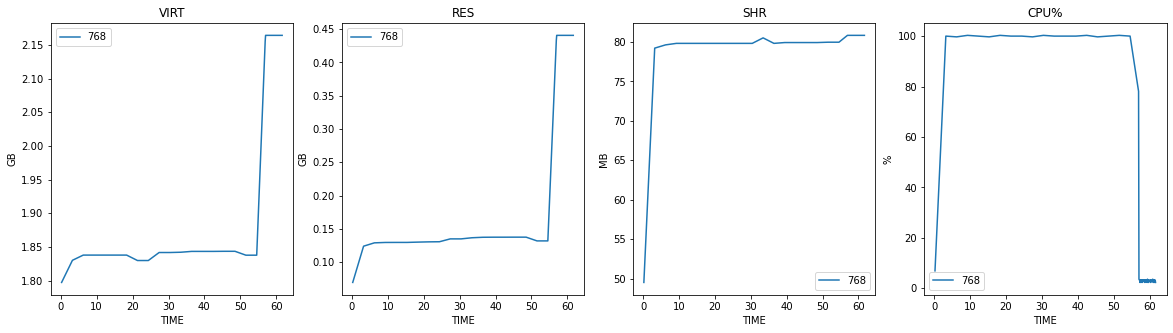

In [6]:
selected = run_df[(run_df['Method']=="2") & 
                    (run_df['device']=="1") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Precision']=="1") &
                    (run_df['Size']=="768") &
                    (run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]
display(selected)

file_name = run_df['File'].iloc[0]

plot_analyse(selected, ["768"])


## Different Methods

#### Device size 1440

CPU


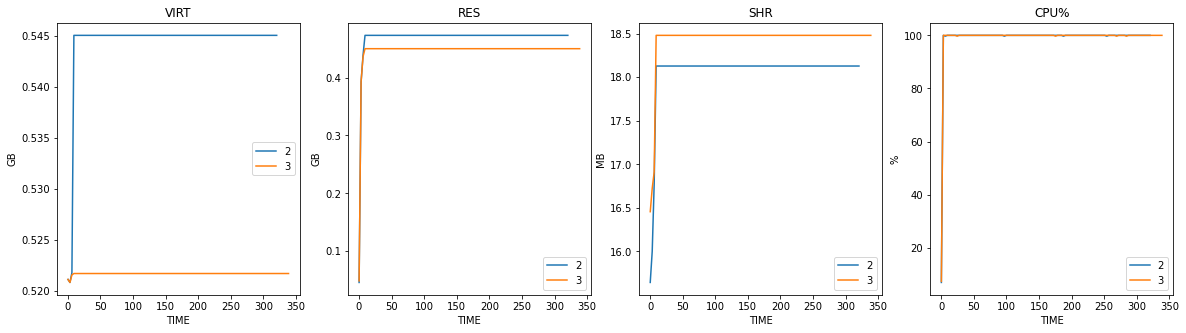

GPU


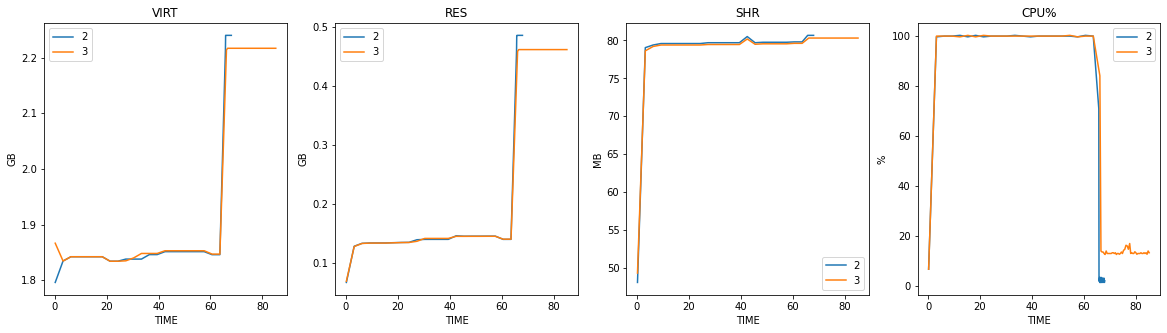

In [57]:
print("CPU")
selected = run_df[(run_df['device']=="0") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Size']=="1440") & 
                    (run_df['Precision']=="1") &
                    (run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]
labels = ["2", "3"]
plot_analyse(selected, labels) 

print("GPU")
selected = run_df[(run_df['device']=="1") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Size']=="1440") & 
                    (run_df['Precision']=="1") &
                    (run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]
labels = ["2", "3"]
plot_analyse(selected, labels) 

#### All

Method 2 CPU


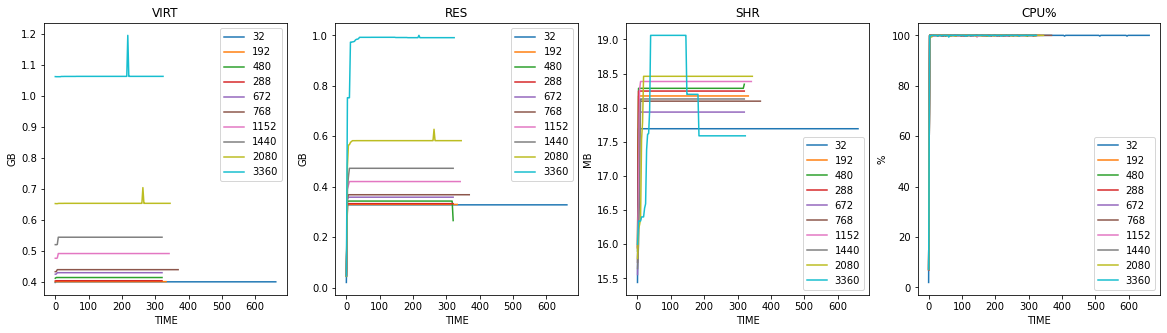

Method 3 CPU


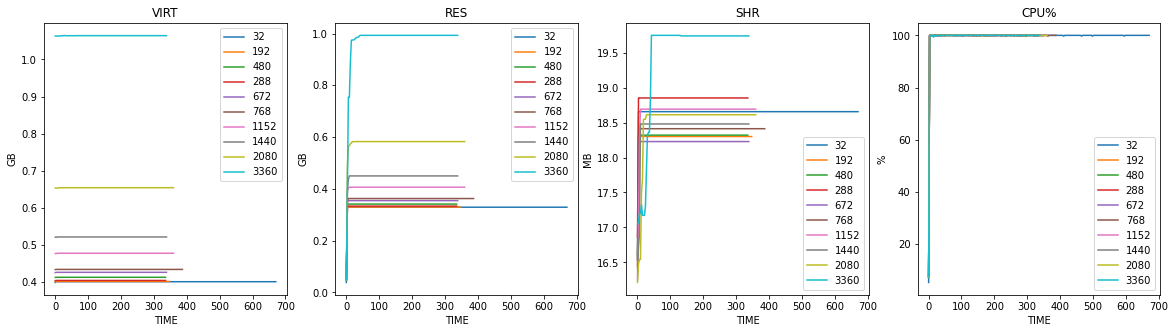

Method 2 GPU


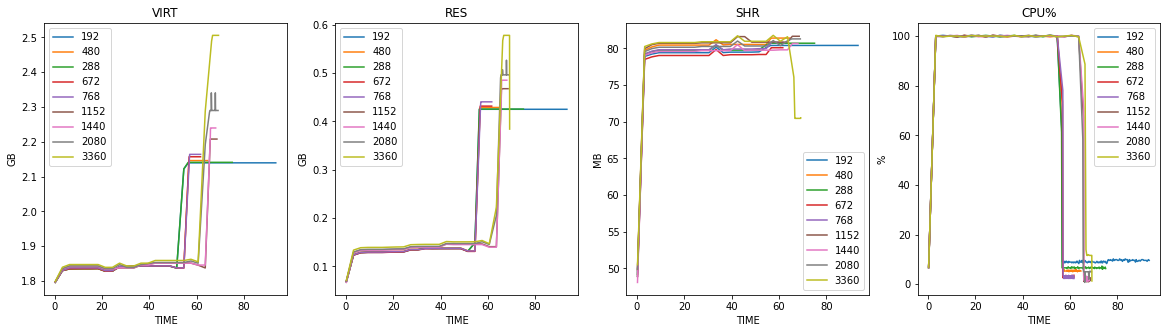

Method 3 GPU


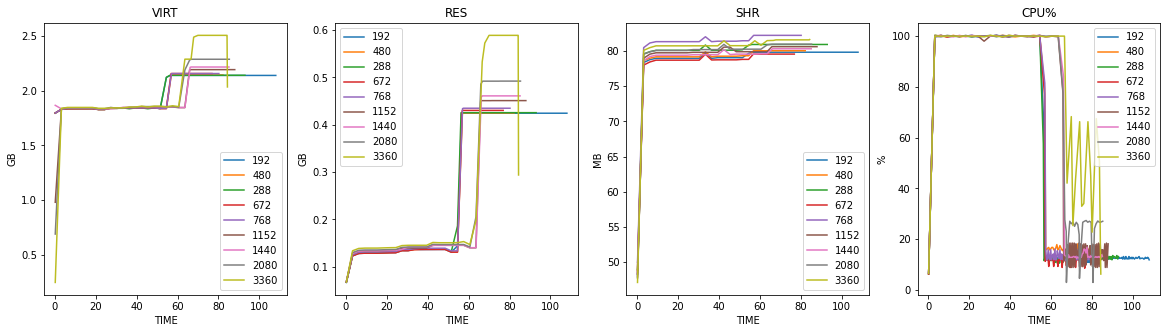

In [44]:
print("Method 2 CPU")
selected = run_df[(run_df['device']=="0") & 
                    (run_df['Method']=="2") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Precision']=="1") &
                    (run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]
labels = selected["Size"].unique()
plot_analyse(selected, labels) 


print("Method 3 CPU")
selected = run_df[(run_df['device']=="0") & 
                    (run_df['Method']=="3") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Precision']=="1") &
                    (run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]
labels = selected["Size"].unique()
plot_analyse(selected, labels) 

print("Method 2 GPU")
selected = run_df[(run_df['device']=="1") & 
                    (run_df['Method']=="2") & 
                    (run_df['Size']!="32") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Precision']=="1") &
                    (run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]
labels = selected["Size"].unique()
plot_analyse(selected, labels) 

print("Method 3 GPU")
selected = run_df[(run_df['device']=="1") & 
                    (run_df['Method']=="3") & 
                    (run_df['Size']!="32") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Precision']=="1") &
                    (run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]
labels = selected["Size"].unique()
plot_analyse(selected, labels) 


Checking errors:


,Method,device,Type,Precision,Size,Threads,Batch-size,Model,File,Status


Checking success:


,Method,device,Type,Precision,Size,Threads,Batch-size,Model,File,Status
15,2,0,yolo_models,1,768,1,1,768-fp16.tflite,768-fp16.tflite_d0_m2_t1.log,SUCCESS
55,3,0,yolo_models,1,768,1,1,768-fp16.tflite,768-fp16.tflite_d0_m3_t1.log,SUCCESS


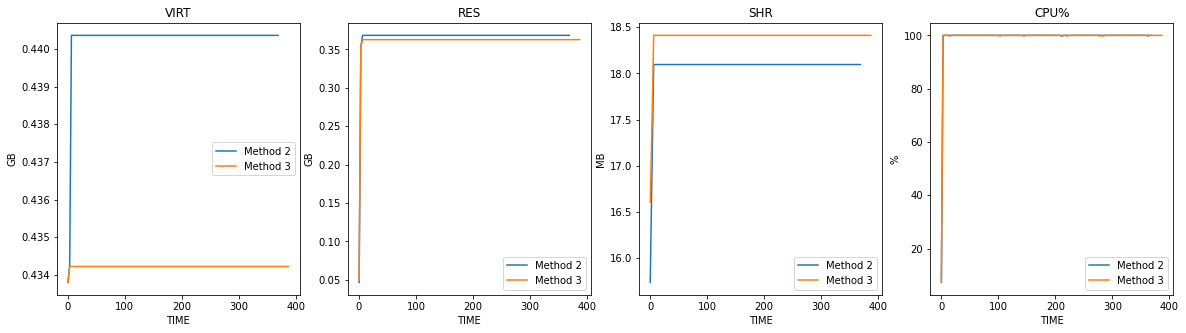

In [7]:
selected = run_df[(run_df['device']=="0") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Precision']=="1") &
                    (run_df['Size']=="768") &
                    (run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]
print("Checking errors:")
display(selected[(selected['Status']=="ERROR")])
print("Checking success:")
display(selected[(selected['Status']=="SUCCESS")])

labels = ["Method 2", "Method 3"]

plot_analyse(selected, labels) 


## image sizes

Checking errors:


,Method,device,Type,Precision,Size,Threads,Batch-size,Model,File,Status


Checking success:


,Method,device,Type,Precision,Size,Threads,Batch-size,Model,File,Status
0,2,1,yolo_models,1,32,1,1,32-fp16.tflite,32-fp16.tflite_d1_m2_t1.log,SUCCESS
1,2,1,yolo_models,1,192,1,1,192-fp16.tflite,192-fp16.tflite_d1_m2_t1.log,SUCCESS
2,2,1,yolo_models,1,480,1,1,480-fp16.tflite,480-fp16.tflite_d1_m2_t1.log,SUCCESS
3,2,1,yolo_models,1,288,1,1,288-fp16.tflite,288-fp16.tflite_d1_m2_t1.log,SUCCESS
4,2,1,yolo_models,1,672,1,1,672-fp16.tflite,672-fp16.tflite_d1_m2_t1.log,SUCCESS
5,2,1,yolo_models,1,768,1,1,768-fp16.tflite,768-fp16.tflite_d1_m2_t1.log,SUCCESS
6,2,1,yolo_models,1,1152,1,1,1152-fp16.tflite,1152-fp16.tflite_d1_m2_t1.log,SUCCESS
7,2,1,yolo_models,1,1440,1,1,1440-fp16.tflite,1440-fp16.tflite_d1_m2_t1.log,SUCCESS
8,2,1,yolo_models,1,2080,1,1,2080-fp16.tflite,2080-fp16.tflite_d1_m2_t1.log,SUCCESS
9,2,1,yolo_models,1,3360,1,1,3360-fp16.tflite,3360-fp16.tflite_d1_m2_t1.log,SUCCESS


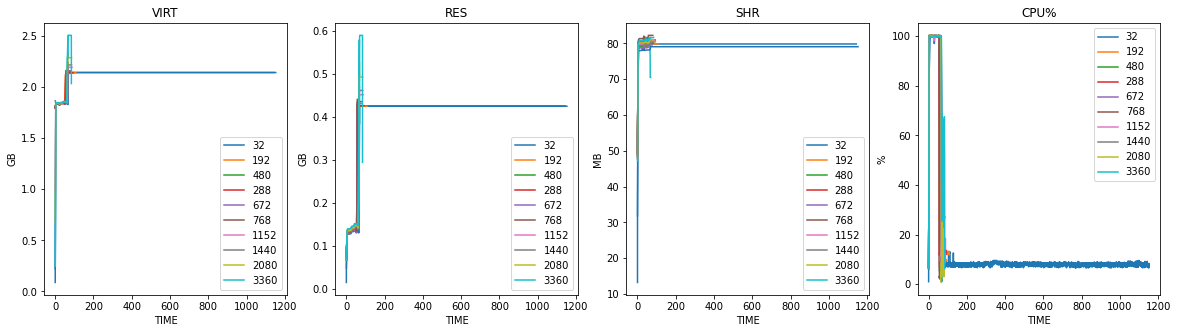

In [23]:
selected = run_df[(run_df['device']=="1") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Precision']=="1") &
                    (run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]
print("Checking errors:")
display(selected[(selected['Status']=="ERROR")])
print("Checking success:")
display(selected[(selected['Status']=="SUCCESS")])

labels = selected["Size"].unique()



plot_analyse(selected, labels) 

## Out of memory GPU

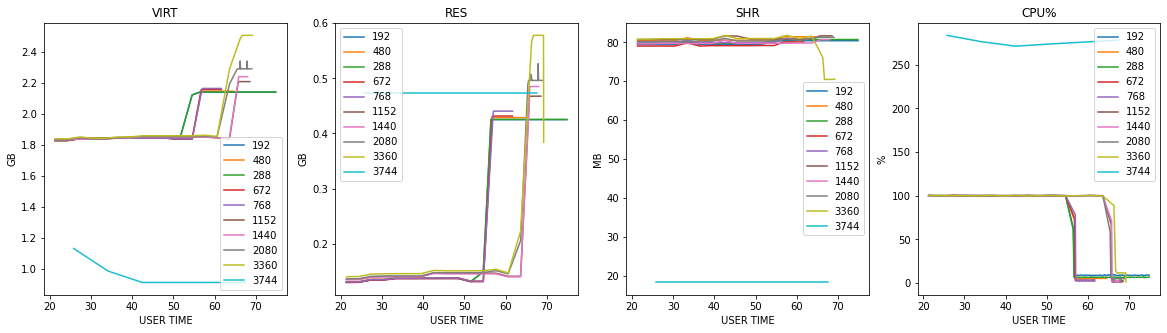

Max for 192
VIRT      2.139688, RES  0.425068, SHR      80.412000, CPU%    100.300000, USER TIME     74.860000
Max for 480
VIRT      2.146156, RES  0.428852, SHR      81.416000, CPU%    100.000000, USER TIME     64.570000
Max for 288
VIRT      2.141124, RES  0.425500, SHR      80.716000, CPU%    100.300000, USER TIME     74.850000
Max for 672
VIRT      2.157136, RES  0.431632, SHR      80.100000, CPU%    100.300000, USER TIME     61.630000
Max for 768
VIRT      2.16406, RES  0.44048, SHR      80.83600, CPU%    100.30000, USER TIME     61.66000
Max for 1152
VIRT      2.208028, RES  0.467680, SHR      81.664000, CPU%    100.300000, USER TIME     68.560000
Max for 1440
VIRT      2.239868, RES  0.485224, SHR      80.676000, CPU%    100.300000, USER TIME     68.030000
Max for 2080
VIRT      2.340816, RES  0.526612, SHR      81.304000, CPU%    100.300000, USER TIME     69.030000
Max for 3360
VIRT      2.506084, RES  0.577992, SHR      81.788000, CPU%    100.300000, USER TIME     69.220000
Ma

AttributeError: 'int' object has no attribute 'strip'

In [38]:
selected = run_df[(run_df['Method']=="2") & 
                    (run_df['device']=="1") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Precision']=="1") &
                    (run_df['Threads']=="1") &
                    (run_df['Size']!="32") & 
                    (run_df['Size']!="4000") & 
                    (run_df['Size']!="3712") & 
                    (run_df['Batch-size']=="1")]
file_name = run_df['File'].iloc[0]
labels = selected["Size"].unique()
df, maxes = plot_analyse(selected, labels, from_time=20, to_time=75)
plot_maxes(maxes, labels)


,Method,device,Type,Precision,Size,Threads,Batch-size,Model,File,Status
898,2,1,yolo_models,1,3712,1,1,3712-fp16.tflite,yolo_3712-fp16.tflite_d1_m2_t1.log,SUCCESS


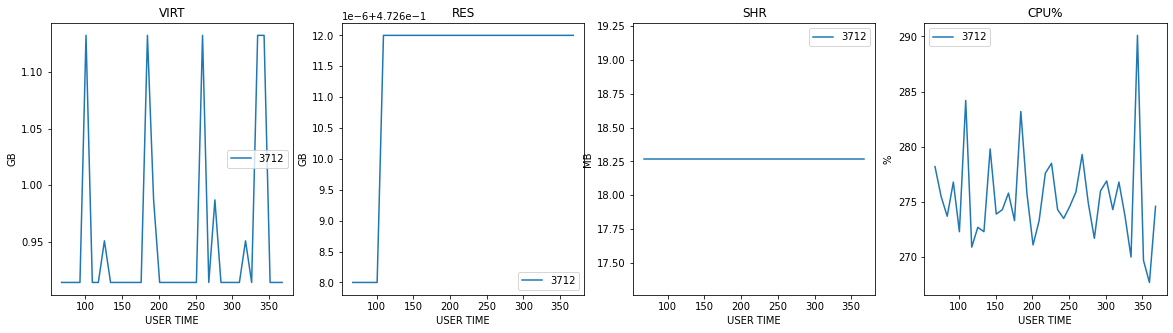

Max for 3712
VIRT      1.132676, RES  0.472612, SHR      18.268000, CPU%    290.100000, USER TIME    367.980000


In [39]:
selected = run_df[(run_df['Method']=="2") & 
                    (run_df['device']=="1") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Precision']=="1") &
                    (run_df['Size']=="3712") &
                    (run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]
display(selected)

file_name = run_df['File'].iloc[0]
df, maxes = plot_analyse(selected, ["3712"], from_time=60)

,Method,device,Type,Precision,Size,Threads,Batch-size,Model,File,Status
896,2,1,yolo_models,1,4000,1,1,4000-fp16.tflite,yolo_4000-fp16.tflite_d1_m2_t1.log,OUT OF MEMORY


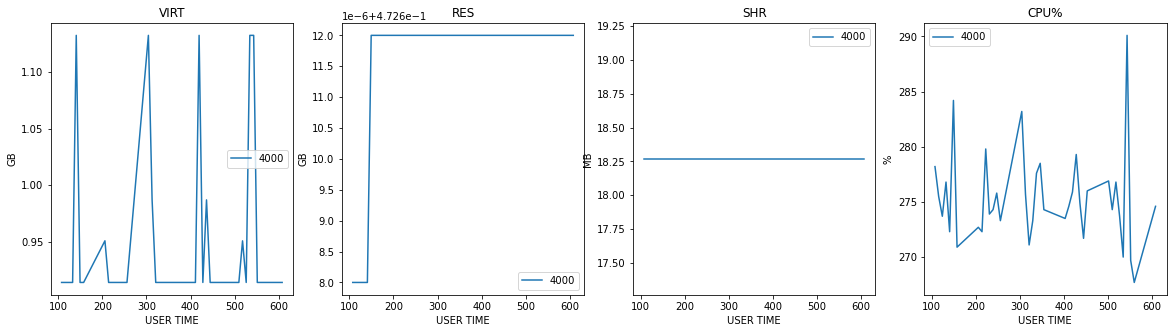

Max for 4000
VIRT      1.132676, RES  0.472612, SHR      18.268000, CPU%    290.100000, USER TIME    607.980000


In [20]:
selected = run_df[(run_df['Method']=="2") & 
                    (run_df['device']=="1") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Precision']=="1") &
                    (run_df['Size']=="4000") &
                    (run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]
display(selected)

file_name = run_df['File'].iloc[0]

df = plot_analyse(selected, ["4000"], from_time=60)

,Method,device,Type,Precision,Size,Threads,Batch-size,Model,File,Status


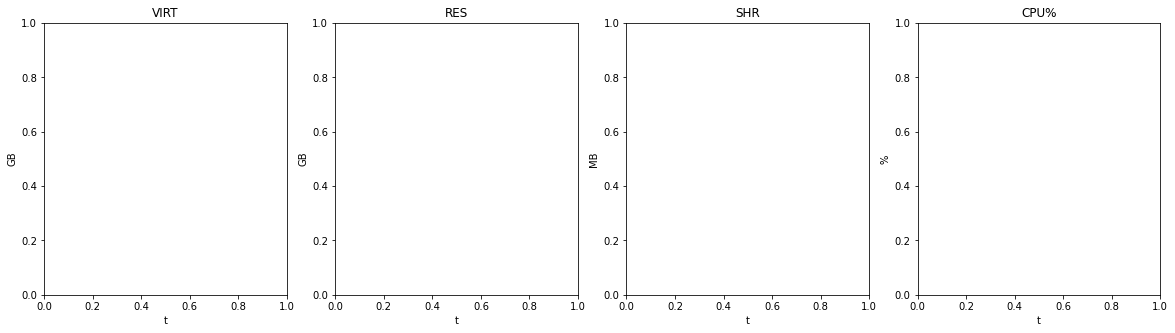

UnboundLocalError: local variable 'df_all' referenced before assignment

In [40]:
selected = run_df[(run_df['Method']=="2") & 
                    (run_df['device']=="1") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Precision']=="1") &
                    (run_df['Size']=="3776") &
                    (run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]
display(selected)

file_name = run_df['File'].iloc[0]

plot_analyse(selected, ["3776"])

## Threads

,Method,device,Type,Precision,Size,Threads,Batch-size,Model,File,Status
17,2,0,yolo_models,1,1440,1,1,1440-fp16.tflite,yolo_1440-fp16.tflite_d0_m2_t1.log,SUCCESS
86,2,0,yolo_models,1,1440,2,1,1440-fp16.tflite,yolo_1440-fp16.tflite_d0_m2_t2.log,SUCCESS
122,2,0,yolo_models,1,1440,3,1,1440-fp16.tflite,yolo_1440-fp16.tflite_d0_m2_t3.log,SUCCESS
158,2,0,yolo_models,1,1440,4,1,1440-fp16.tflite,yolo_1440-fp16.tflite_d0_m2_t4.log,SUCCESS
194,2,0,yolo_models,1,1440,5,1,1440-fp16.tflite,yolo_1440-fp16.tflite_d0_m2_t5.log,SUCCESS


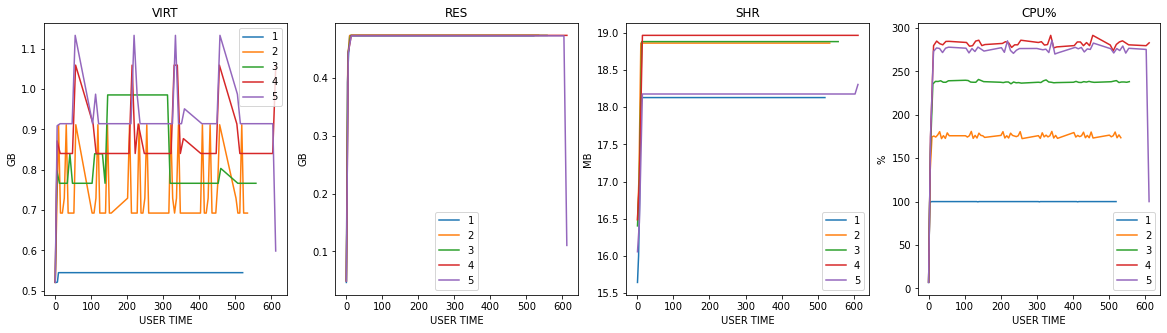

Max for 1
VIRT      0.545040, RES  0.472992, SHR      18.128000, CPU%    100.000000, USER TIME    520.360000
Max for 2
VIRT      0.911344, RES  0.473724, SHR      18.860000, CPU%    180.800000, USER TIME    533.670000
Max for 3
VIRT      0.985116, RES  0.473620, SHR      18.880000, CPU%    240.600000, USER TIME    557.170000
Max for 4
VIRT      1.058888, RES  0.473700, SHR      18.964000, CPU%    291.400000, USER TIME    612.250000
Max for 5
VIRT      1.132660, RES  0.472804, SHR      18.304000, CPU%    285.500000, USER TIME    612.020000


In [18]:
selected = run_df[(run_df['Method']=="2") & 
                    (run_df['device']=="0") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Precision']=="1") &
                    (run_df['Size']=="1440") &
                    #(run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]
display(selected)

file_name = run_df['File'].iloc[0]
labels = selected["Threads"].unique()

df =plot_analyse(selected, labels)

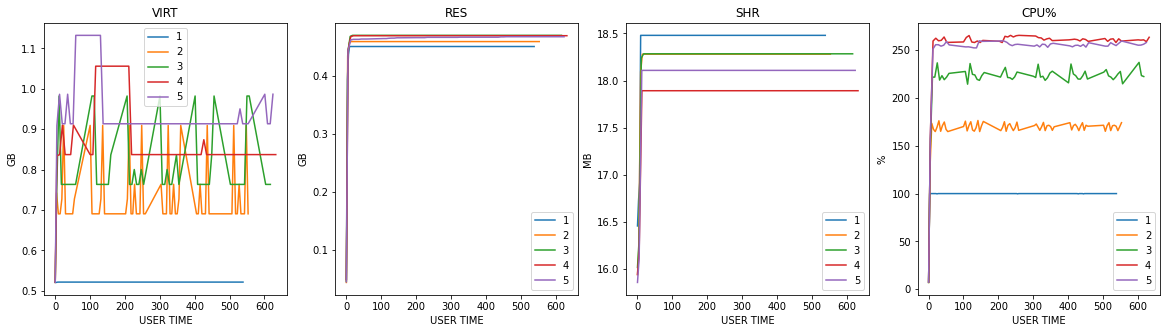

Max for 1
VIRT      0.521672, RES  0.449952, SHR      18.480000, CPU%    100.000000, USER TIME    538.500000
Max for 2
VIRT      0.909364, RES  0.458460, SHR      18.280000, CPU%    176.500000, USER TIME    553.080000
Max for 3
VIRT      0.982136, RES  0.469172, SHR      18.284000, CPU%    237.300000, USER TIME    616.890000
Max for 4
VIRT      1.055908, RES  0.468576, SHR      17.892000, CPU%    265.600000, USER TIME    632.410000
Max for 5
VIRT      1.132184, RES  0.466804, SHR      18.108000, CPU%    259.900000, USER TIME    624.270000


In [19]:
selected = run_df[(run_df['Method']=="3") & 
                    (run_df['device']=="0") & 
                    (run_df['Type']=="yolo_models") & 
                    (run_df['Precision']=="1") &
                    (run_df['Size']=="1440") &
                    #(run_df['Threads']=="1") &
                    (run_df['Batch-size']=="1")]
#display(selected)

file_name = run_df['File'].iloc[0]
labels = selected["Threads"].unique()

df =plot_analyse(selected, labels)